/home/franchesoni/env_sandbox/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created spatial emb loss function with: to_center: False, n_sigma: 1, foreground_weight: 1
importing external...
importing internal...
firing...


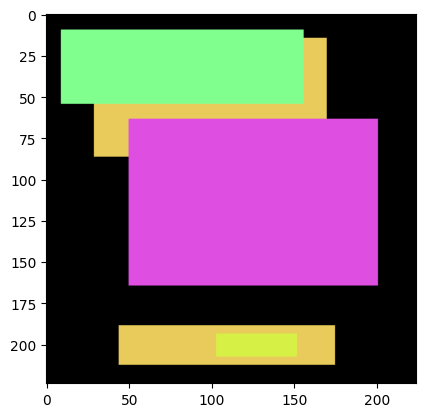

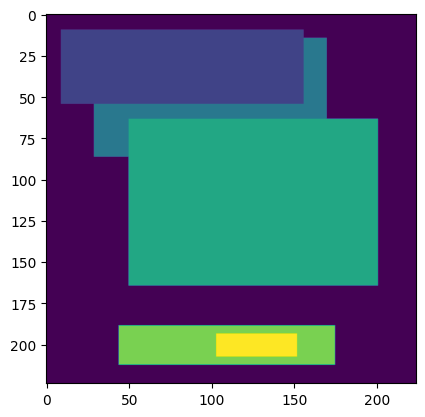

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

def minmaxnorm(x):
    x = np.array(x)
    return (x - x.min()) / (x.max() - x.min())

ckpt_path = 'runs/Dec28_19-58-35_weird-power_ours_genn/last_validated_model.pth'
img = Image.open('datadir/image_99998.png')
masks = Image.open('datadir/mask_99998.png')

from network import get_network
from trainer import TrainableModule
from engine import load_from_ckpt

net = get_network(output_channels=10, dummy=True, model='vitregs')
plmodel = TrainableModule(net, loss_fn=None)
plmodel = load_from_ckpt(plmodel, ckpt_path, strict=False)
plmodel.eval()

iimg = torch.from_numpy(np.array(img) / 255).permute(2,0,1).float()[None]
with torch.no_grad():
    out = plmodel(iimg)

plt.figure()
plt.imshow(minmaxnorm(img))
plt.figure()
plt.imshow(minmaxnorm(masks))


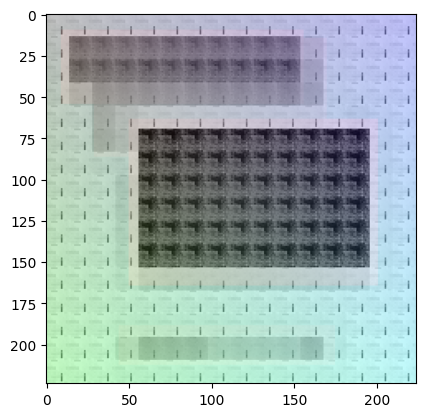

In [8]:
from extras.utils import to_img
from losses import symlog


img_size = iimg.shape[-2:]
H, W = img_size
B = 1
n_rows, n_cols = img_size
rows = torch.linspace(0, 1, n_rows).view(1, -1, 1).expand(1, n_rows, n_cols)
cols = torch.linspace(0, 1, n_cols).view(1, 1, -1).expand(1, n_rows, n_cols)
xym = torch.cat((rows, cols), 0)
xym_s = xym.reshape(1, 2, H, W).expand(B, 2, H, W)  # B, 2, H, W

# create base based on image and pos map
base = torch.cat([iimg, xym_s], dim=1)  # B, 5, H, W
# get offsets
offsets = symlog(out[:, 5])
rgbxy2 = base + offsets  # B, 5, H, W

plt.figure()
plt.imshow(to_img(rgbxy2, 2))


/home/franchesoni/env_sandbox/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


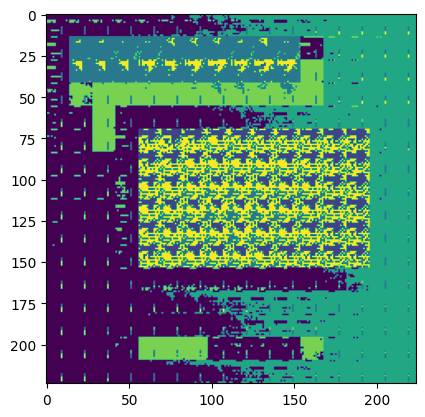

In [10]:
embeddings = rgbxy2.reshape(5, -1).permute(1,0)
# now cluster the embeddings using sklearn's kmeans 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(embeddings.numpy())
labels = kmeans.labels_
labels = labels.reshape(H, W)
plt.figure()
plt.imshow(labels)